In [2]:
import pandas as pd
import numpy as np

In [1]:
# import stock data from yfinance

import yfinance as yf
df = yf.download('TSLA', start='2010-01-01', end='2024-12-31')
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


<Axes: xlabel='Date'>

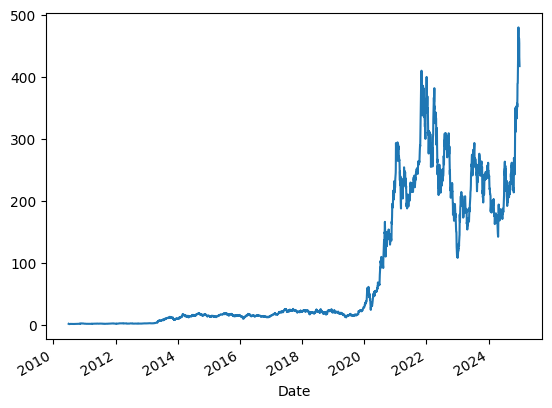

In [3]:
# plot the stock data
import matplotlib.pyplot as plt
df['Close'].plot()

In [4]:
df["target"] = df["Adj Close"].shift(-1)
df["target"] = np.where(df["target"] > df["Adj Close"], 1, 0)
df.head()

,Open,High,Low,Close,Adj Close,Volume,target
Date,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,0
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,0
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,0
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,0
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,0


In [5]:
def generate_image(df,days,h):
    w = days * 3
    img = np.zeros((h, w))
    scaling = h - 1
    MIN = min(df['Low'].iloc[:days].min(), df['Open'].iloc[:days].min(), df['Close'].iloc[:days].min())
    MAX = max(df['High'].iloc[:days].max(), df['Open'].iloc[:days].max(), df['Close'].iloc[:days].max())
 
    for i in range(days):
        open = int(((df['Open'].iloc[i] - MIN) / (MAX - MIN)) * scaling)
        high = int(((df['High'].iloc[i] - MIN) / (MAX - MIN)) * scaling)
        low = int(((df['Low'].iloc[i] - MIN) / (MAX - MIN)) * scaling)
        close = int(((df['Close'].iloc[i] - MIN) / (MAX - MIN)) * scaling)
        
        

        img[h - open  - 1, i*3] = 255
        img[h - high - 1 : h - low , i*3+1] = 255
        img[h - close - 1, i*3+2] = 255

    return img

In [154]:
img = generate_image(df[10:21], 10, 30)

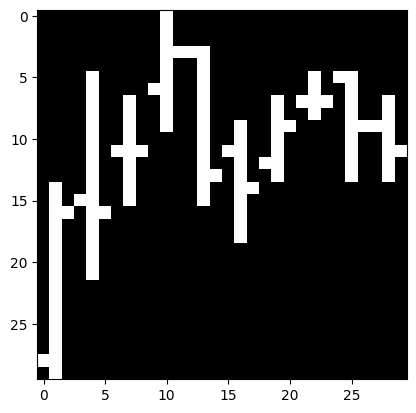

In [155]:
plt.imshow(img, cmap='gray')

In [6]:
def generate_dataset(df, days, h):
    X = []
    y = []
    for i in range(len(df) - days):
        X.append(generate_image(df[i: i + days], days, h))
        y.append(df["target"].iloc[i + days - 1])
    return np.array(X), np.array(y)

In [7]:
X, y = generate_dataset(df, 5, 30)

In [8]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X, y = generate_dataset(df, 5, 30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.shape,y_train.shape

((2916, 30, 15), (2916,))

In [84]:
# CNN model in pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, height, width ,num_classes=2):
        super(CNN, self).__init__()
        
        # Calculate the size after convolution and pooling
        self.height = height
        self.width = width
        self.kernel_size = 2

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=self.kernel_size)
        self.pool = nn.MaxPool2d(kernel_size=self.kernel_size, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=self.kernel_size)
        
        # Calculate the flattened size after the second convolution and pooling
        def conv2d_output_size(size, kernel_size=self.kernel_size, stride=1, padding=0):
            return (size - self.kernel_size + 2 * padding) // stride + 1

        conv1_h = conv2d_output_size(height, kernel_size=self.kernel_size)
        conv1_w = conv2d_output_size(width, kernel_size=self.kernel_size)
        pool1_h = conv1_h // 2
        pool1_w = conv1_w // 2

        conv2_h = conv2d_output_size(pool1_h, kernel_size=self.kernel_size)
        conv2_w = conv2d_output_size(pool1_w, kernel_size=self.kernel_size)
        pool2_h = conv2_h // 2
        pool2_w = conv2_w // 2

        self.flattened_size = pool2_h * pool2_w * 64

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage
  # Image dimensions (grayscale)



In [85]:
from sklearn.model_selection import train_test_split
days, height = 3, 30
X, y = generate_dataset(df, days, height)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train).float().unsqueeze(1)
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float().unsqueeze(1)
y_test = torch.from_numpy(y_test).long()

In [86]:
width = 3 * days
model = CNN(height,width)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [87]:
X_train.shape, y_train.shape

(torch.Size([2918, 1, 30, 9]), torch.Size([2918]))

In [88]:
# train the model
num_epochs = 50
losses = []
val_loss = []
accuracy_arr = []
model.train()
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    # validate the model
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
        # print(f'Accuracy: {accuracy}, Loss: {loss.item()}')
        val_loss.append(loss.item())
        accuracy_arr.append(accuracy)

Epoch [10/50], Loss: 1.6093347072601318
Epoch [20/50], Loss: 1.2149513959884644
Epoch [30/50], Loss: 1.062863826751709
Epoch [40/50], Loss: 0.9482979774475098
Epoch [50/50], Loss: 0.8736271858215332


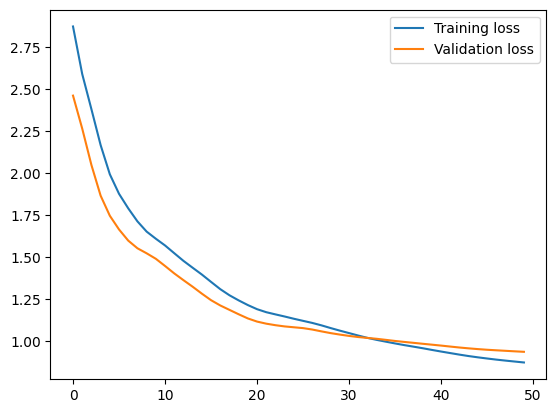

In [90]:
plt.plot(losses, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.show()

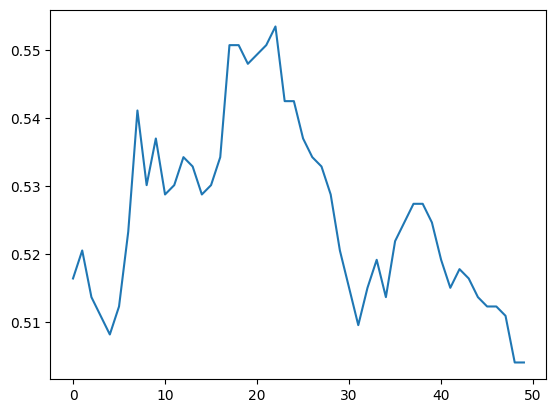

In [91]:
plt.plot(accuracy_arr, label='Accuracy')


In [92]:
# test the model
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f'Accuracy: {accuracy}')

Accuracy: 0.5041095890410959
